#Examples showing how to create and manipulate boundaries

In [16]:
% pylab inline
import numpy as np
import matplotlib.pyplot as plt
from pyvm.models.vm import VM

Populating the interactive namespace from numpy and matplotlib


## Dipping boundaries

Initialize a model, add dipping boundaries, and fill layers with constant velocities:

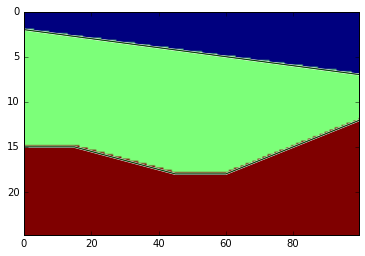

In [17]:
# define the model domain in terms of grid dimensions, spacing, and origin
vm = VM(shape=(200, 1, 100), spacing=(0.5, 1, 0.25), origin=(0, 0, 0))

# add a sloping boundary
z = np.reshape(2 + 0.05*(vm.grid.x),(vm.nx,1))
vm.insert_interface(z)

# piecewise defined boundary
specs = [#xstart, xend, slope
    [0., 15., 0.],
    [15., 45., 0.1],
    [45., 60., 0.],
    [60., vm.r2[0], -0.15]]

z0 = 15.  # intial depth at left-hand side of model

# build full boundary
z = np.ones(vm.nx)
for x0, x1, m in specs:
    ix = vm.xrange2i(x0, x1)
    x = vm.grid.x[ix]
    z[ix] = z0 + m * (x - x[0])
    
    z0 = z[ix[-1]]

# add the boundary
vm.insert_interface(np.reshape(z, (vm.nx, 1)))

# add some velocities
vm.define_constant_layer_velocity(0, 1.5)
vm.define_constant_layer_velocity(1, 2.5)
vm.define_constant_layer_velocity(2, 3.5)

# plot
vm.plot()

## Modifying existing boundaries

Add a cosine perturbation to the first boundary:

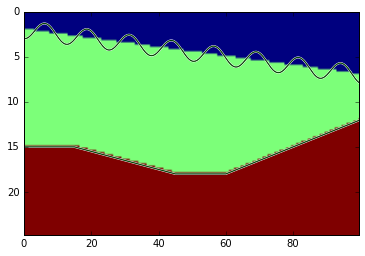

In [18]:
vm.rf[0] += np.cos(0.5 * vm.grid.x).reshape((vm.nx, 1))

vm.plot()

Note that boundary has changed, but the velocity grid has not.  We can update the velocity grid with:

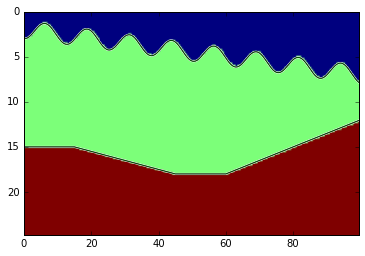

In [19]:
vm.define_constant_layer_velocity(0, 1.5)
vm.define_constant_layer_velocity(1, 2.5)

vm.plot()

## Smoothing boundaries

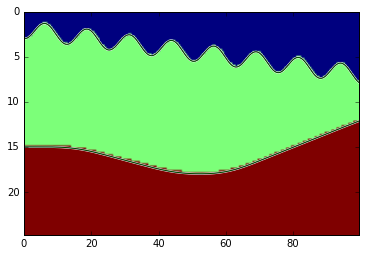

In [20]:
vm.smooth_interface(1, nwin=50)

vm.define_constant_layer_velocity(1, 2.5)
vm.define_constant_layer_velocity(2, 3.5)

vm.plot()

##Fixing Pinchouts

The tomography code requires that boundaries not cross each other.  That is:

vm.rf[i, :, :] < vm.rf[i+1, :, :]

If crossings do exist, the tomography code will fail, as will many functions in PyVM.  As an example, let's move the 2nd boundary up so that it crosses the first:

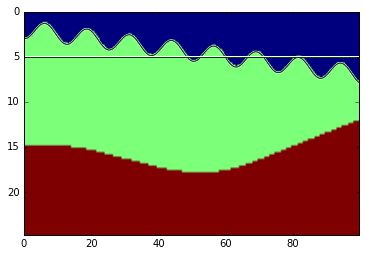

In [21]:
vm.rf[1] = 5. * np.ones((vm.nx, vm.ny))

vm.plot()

Now, let's try to define velocities in the bottom layer:

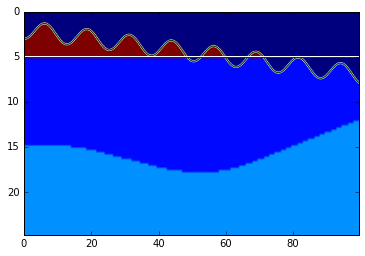

In [22]:
vm.define_constant_layer_velocity(1, 9.)

vm.plot()

Notice that this function only modified velocities where rf[1, :, :] < rf[2, :, :].

Generally, it is easiest to insert boundaries that do not cross. If crossings are created by, for example, smoothing boundaries of thin layers, they can be fixed like this:

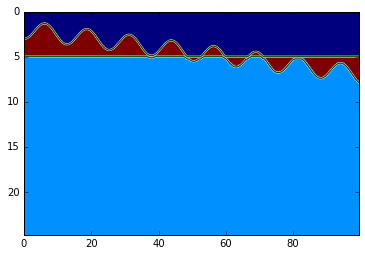

In [23]:
# put boundaries in correct order
for ir in range(1, vm.nr):
    _top = vm.rf[ir - 1]
    _bot = vm.rf[ir]

    top = np.minimum(_top, _bot)
    bot = np.maximum(_top, _bot)

    vm.rf[ir - 1] = top
    vm.rf[ir] = bot

# ensure minimum spacing between boundaries
min_dz = vm.dz
for ir in range(1, vm.nr):
    dz = vm.rf[ir] - vm.rf[ir  - 1]
    idx = np.nonzero(dz < min_dz)
    vm.rf[ir][idx] += min_dz  - dz[idx]
    
# reassign velocities
vm.define_constant_layer_velocity(1, 9.)
vm.define_constant_layer_velocity(2, 3.5)

vm.plot()

This is also what the function `fix_pinchouts` does:

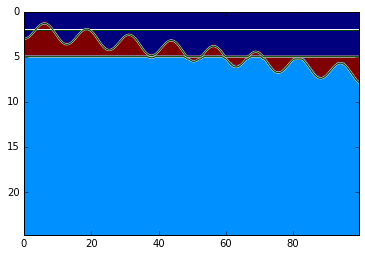

In [24]:
vm.insert_interface(2)
vm.plot()

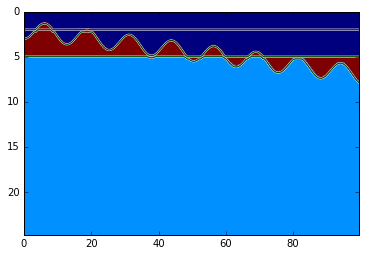

In [25]:
vm.fix_pinchouts()
vm.plot()

Note that `fix_pinchouts` does not modify the velocity grid.  Again, this can be fixed with:

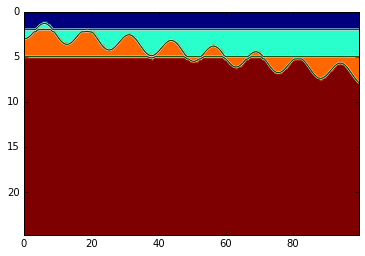

In [26]:
vm.define_constant_layer_velocity(0, 1)
vm.define_constant_layer_velocity(1, 2)
vm.define_constant_layer_velocity(2, 3)

vm.plot()